### 0. Imports

In [16]:
%load_ext autoreload
%autoreload 2

# Data transformation
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np


# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Progress loops
# -----------------------------------------------------------------------
from tqdm import tqdm

# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs


# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr
from scipy.stats.mstats import winsorize
from scipy.stats import trim_mean

# work with serialized pickle files
# -----------------------------------------------------------------------
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction to clustering results analysis

The purpose of this notebook is to analyse the resulting clusters selected from the modelling of clusters to provide recommendations and business actions to leverage the segmentation of customers performed.

## 1.1 Data import

In [17]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")
global_superstore.head(2)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,market,product_id,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,US,PR-0,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-05,Second Class,JR-16210,Justin Ritter,Corporate,APAC,PR-1,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


## 1.2 Cluster import

In [18]:
customer_cluster_labels = pd.read_pickle("../data/clusters/customer_Aggregated_v1_k4.pkl")
customer_cluster_labels.head(2)

,median_orders_month,median_spending_order,median_discount,discount_corr,clusters_kmeans
customer_id,,,,,
AA-10315,1.0,270.60,0.000000,0.045609,3
AA-10375,1.0,90.48,0.024334,-0.072842,1


Create a mapping for cluster labels to customer_ids.

In [19]:
cluster_mapping = customer_cluster_labels["clusters_kmeans"].to_dict()
global_superstore["customer_cluster"] = global_superstore["customer_id"].map(cluster_mapping)

Save the labeled dataset.

In [20]:
global_superstore.to_pickle("../data/clusters/global_superstore_clusters.pkl")

## 1.3 metric calculation

In [31]:
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]
global_superstore["original_price"] = global_superstore["sales"] + global_superstore["discounted_price"]
monthly_discounts = global_superstore[global_superstore["customer_cluster"]=="0"].set_index("order_date")[["discounted_price","original_price","profit","sales"]].resample("MS").sum()
monthly_discounts["discount"] = monthly_discounts["discounted_price"] / monthly_discounts["original_price"]
monthly_discounts["margin_af_discount"] = monthly_discounts["profit"] / monthly_discounts["sales"]
monthly_discounts = monthly_discounts.to_period("M")
monthly_discounts["order_date"] = monthly_discounts.index.astype("str")
monthly_discounts.head()

,discounted_price,original_price,profit,sales,discount,margin_af_discount,order_date
order_date,,,,,,,
2011-01,5161.32224,27813.72,249.85596,22652.39776,0.185567,0.011030,2011-01
2011-02,3696.58834,25126.48,2826.86306,21429.89166,0.147119,0.131912,2011-02
2011-03,4943.91636,26699.62,3564.30774,21755.70364,0.185168,0.163833,2011-03
2011-04,6716.66070,33881.60,1566.72750,27164.93930,0.198239,0.057675,2011-04
2011-05,9399.66436,42280.16,856.32074,32880.49564,0.222319,0.026043,2011-05


# 2. Cluster analysis

### Company profits per cluster

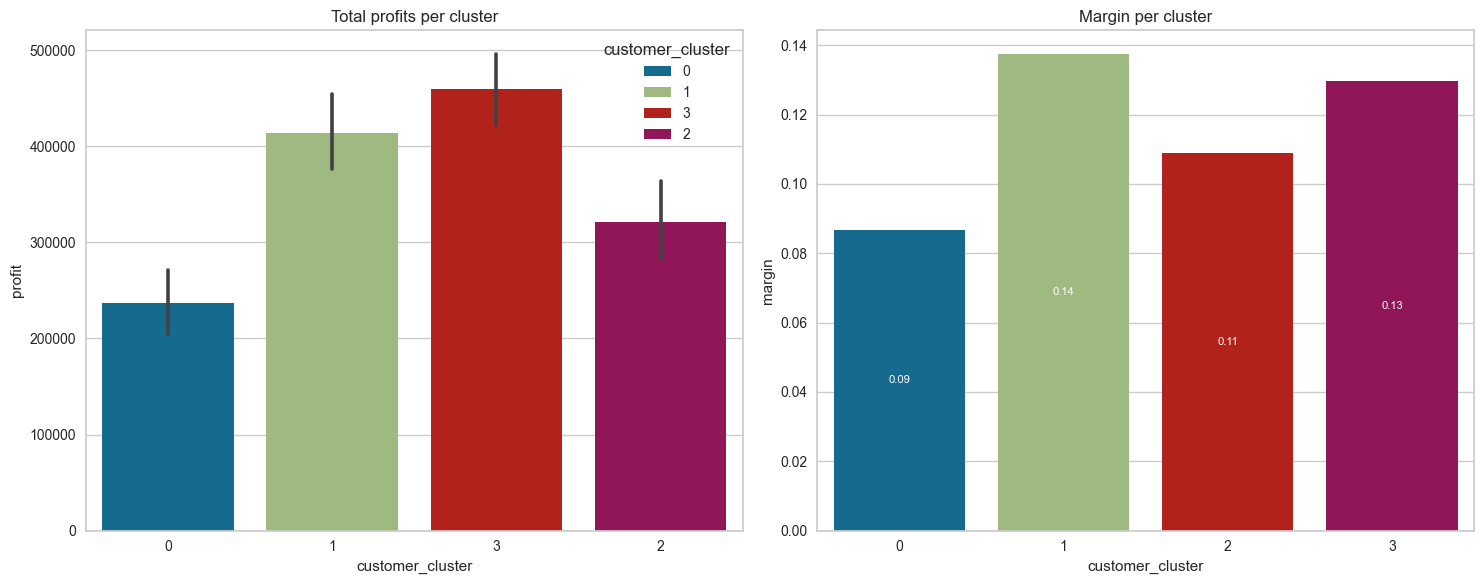

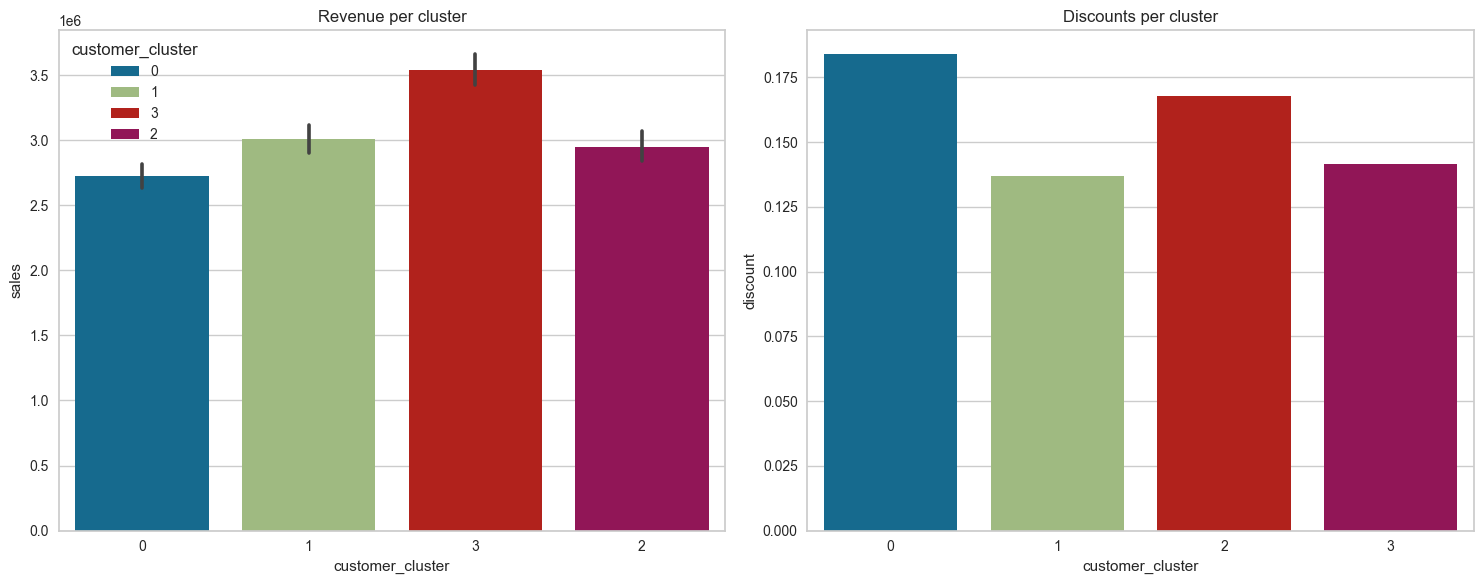

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].set_title("Total profits per cluster")
sns.barplot(data=global_superstore,
            x="customer_cluster",
            y="profit",
            estimator="sum",
            hue="customer_cluster",
            ax=axes[0])

cluster_discount = global_superstore.groupby("customer_cluster").agg(total_revenue=("sales", "sum"),
                                                                     total_profit=("profit", "sum")
                                                                     ).assign(margin=lambda df: df["total_profit"] / df["total_revenue"])

axes[1].set_title("Margin per cluster")
ax = sns.barplot(data=cluster_discount,
                 x="customer_cluster",
                 y="margin",
                 estimator="mean",
                 hue="customer_cluster",
                 ax=axes[1])
dvs.plot_bar_labels(ax)

plt.tight_layout()
plt.show()

# second set of plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].set_title("Revenue per cluster")
sns.barplot(data=global_superstore,
            x="customer_cluster",
            y="sales",
            estimator="sum",
            hue="customer_cluster",
            ax=axes[0])

cluster_discount = global_superstore.groupby("customer_cluster").agg(total_discounted_price=("discounted_price", "sum"),
                                                                     total_original_price=("original_price", "sum")
                                                                     ).assign(discount=lambda df: df["total_discounted_price"] / df["total_original_price"])

axes[1].set_title("Discounts per cluster")
sns.barplot(data=cluster_discount,
            x="customer_cluster",
            y="discount",
            estimator="mean",
            hue="customer_cluster",
            ax=axes[1])

plt.tight_layout()
plt.show()


As expected, cluster 0 shows the least profit for the company. Therefore, the recommendation is to focus on that cluster mainly for promotions and inventory access alleviation.

Cluster 1, although not the most profitable, is the cluster that requires the least maintenance as they keep their spending constant even if there are no discounts. For this cluster, keeping supply is the only thing that is needed.

Cluster 3 is the highest spender. They provide high total profits, although their margin is not that high, because of the revenue they bring in. 

Cluster 2 reacts to discounts, spending more if there are discounts, but does not need them to spend, that makes their margins high. However, they do not tend to spend that much in general. Therefore, they provide less total profits than clusters 1 and 3.

## 2.1 Focus on cluster 1

Given that this cluster is the lowest maintenance, it is interesting to see what they buy the most, to maintain a good service of supply, and what they bring in the most profit with. That way, we stay as a referece provider for small things, keeping the cross-selling opportunity for some more profitable items.

### What segments do they belong to?

In [10]:
global_superstore[global_superstore["customer_cluster"]=="1"].groupby("segment").agg(unique_customers=("customer_id","nunique"))

,unique_customers
segment,
Consumer,110
Corporate,54
Home Office,46


### What do these customers buy the most?

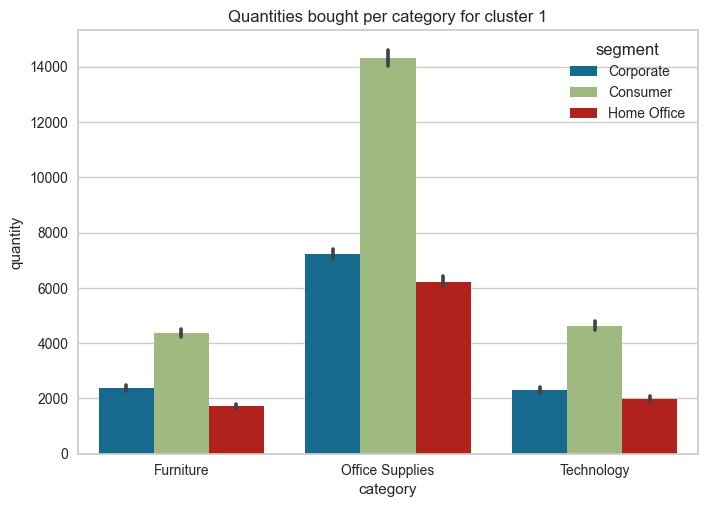

In [44]:
plt.title("Quantities bought per category for cluster 1")
sns.barplot(data=global_superstore[global_superstore["customer_cluster"]=="1"],
            x="category",
            y="quantity",
            hue="segment",
            estimator="sum")
plt.show()

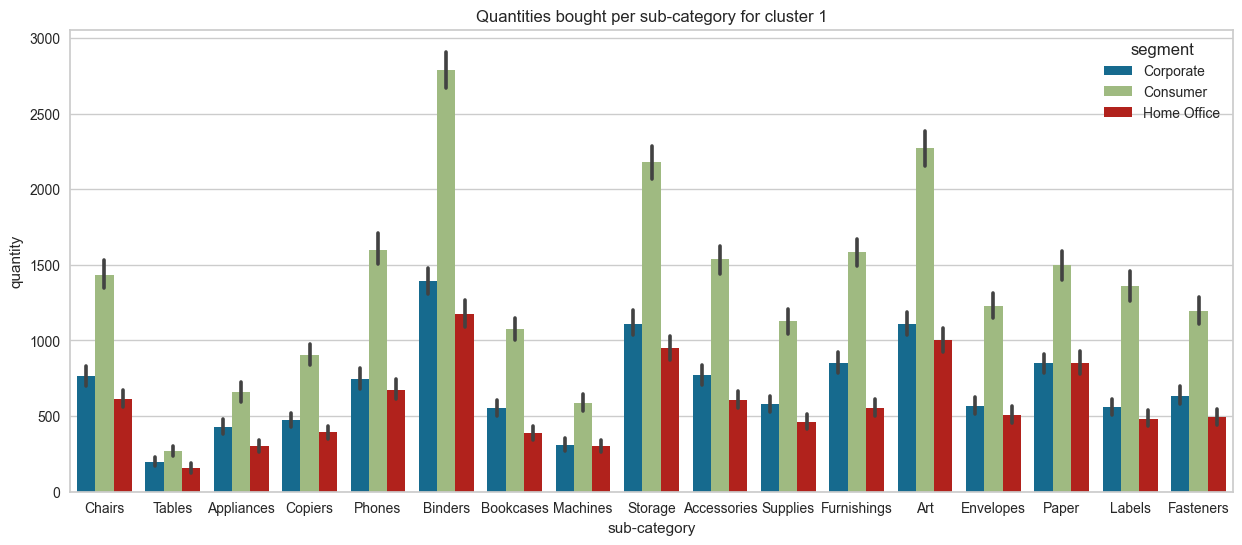

In [45]:
plt.figure(figsize=(15,6))
plt.title("Quantities bought per sub-category for cluster 1")
sns.barplot(data=global_superstore[global_superstore["customer_cluster"]=="1"],
            x="sub-category",
            y="quantity",
            hue="segment",
            estimator="sum")
plt.show()

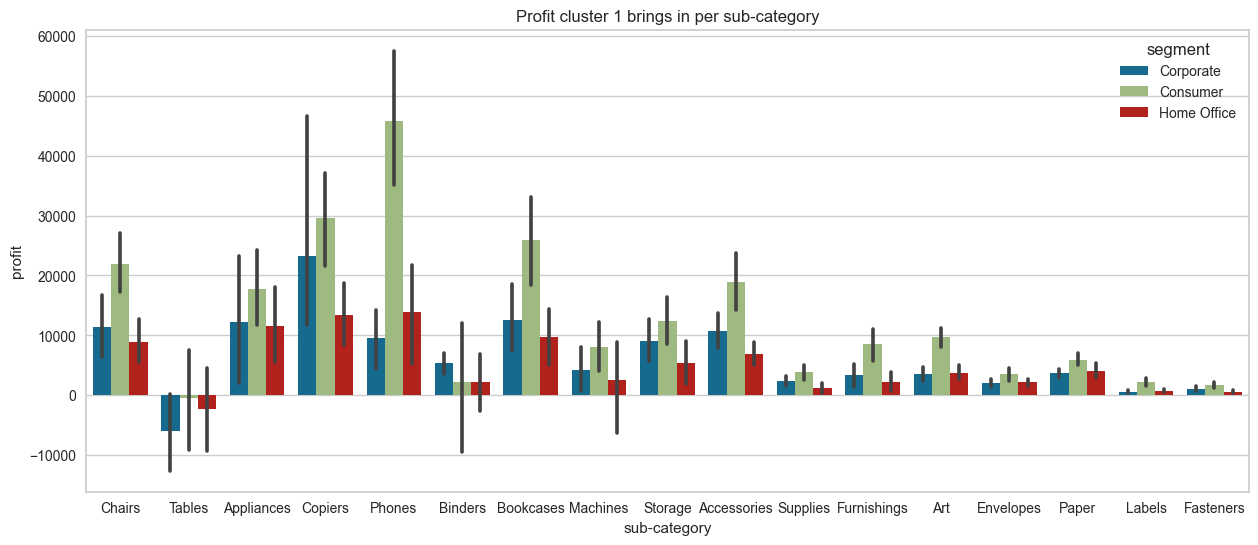

In [47]:
plt.figure(figsize=(15,6))
plt.title("Profit cluster 1 brings in per sub-category")
sns.barplot(data=global_superstore[global_superstore["customer_cluster"]=="1"],
            x="sub-category",
            y="profit",
            hue="segment",
            estimator="sum")
plt.show()

The idea then is to make a forecast for the subcategories these clients buy most frequently, but for the general public of the store. That way, supply can be guaranteed and if underprediction is made, we can prioritise on top clients. Then, a forecast for the top profitable items can be made in order to guarantee our best profit.